In [2]:
from qiskit.quantum_info import Statevector
from QuditsOnQubits import QuditsOnQubits
import numpy as np
import networkx as nx
from numpy.linalg import multi_dot
import matplotlib.pyplot as plt

Definicja Z i X qutrytowych zakodowanych na qubitach

In [3]:
omega = np.exp(2*np.pi*1.j/3)
Z = [[1, 0, 0, 0], [0, omega, 0, 0], [0, 0, omega*omega, 0], [0, 0, 0, 1]]
X = [[0,0,1,0], [1,0,0,0], [0,1,0,0],[0,0,0,1]]

In [4]:
qubit0 = np.array([[1], [0]])
qubit1 = np.array([[0], [1]])

Qtrt0 = np.kron(qubit0, qubit0)
Qtrt1 = np.kron(qubit0, qubit1)
Qtrt2 = np.kron(qubit1, qubit0)

In [5]:
Qtrt0

array([[1],
       [0],
       [0],
       [0]])

In [6]:
Qtrt1

array([[0],
       [1],
       [0],
       [0]])

In [7]:
Qtrt2

array([[0],
       [0],
       [1],
       [0]])

In [8]:
np.dot(Z, Qtrt2)

array([[ 0. +0.j       ],
       [ 0. +0.j       ],
       [-0.5-0.8660254j],
       [ 0. +0.j       ]])

Tworze graf ame43

5

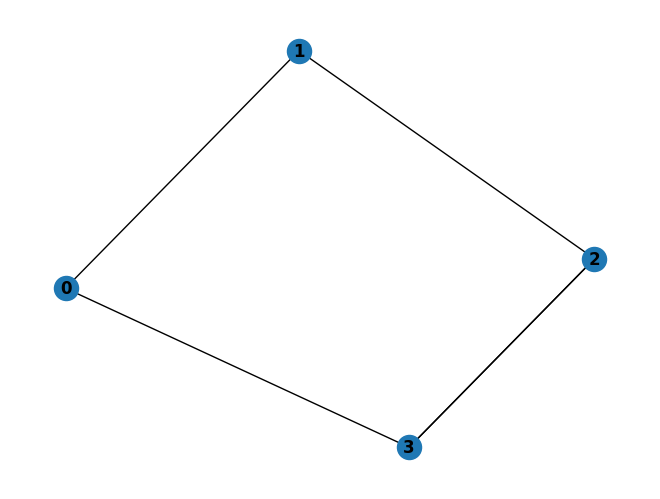

In [9]:
SQ = nx.MultiGraph()

#dodawanie wezlow
SQ.add_nodes_from([0, 3])

#dodawanie kolejnych krawedzi
SQ.add_edge(0, 1)
SQ.add_edge(1, 2)
SQ.add_edge(2, 3)
SQ.add_edge(2, 3)
SQ.add_edge(3, 0)

#rysowania grafu
nx.draw(SQ, with_labels=True, font_weight='bold')

#wypisywanie liczby krawedzi
SQ.number_of_edges()

Tworze stan grafowy uzywajac stworzonej biblioteki QuditsOnQubits gdzie w argumencie mam graf

In [10]:
ame43 = QuditsOnQubits(SQ)

Tworze obwod z grafu

In [11]:
ame43circ = ame43.circuit

Tworze stabilizatory według pracy Santosa. Wzor nr. 42 na stronie 11. 

In [12]:
G1 = np.kron(np.kron(np.kron(X, Z), np.identity(4)), Z)
G1G2 = np.kron(np.kron(np.kron(np.dot(X, Z), np.dot(Z, X)), Z), Z)
G1G2pow2 = np.kron(np.kron(np.kron(multi_dot([X, Z, Z]), multi_dot([Z, X, X])), multi_dot([Z, Z])), Z)
G3 = np.kron(np.kron(np.kron(np.identity(4), Z), X), multi_dot([Z, Z]))
G1G4 = np.kron(np.kron(np.kron(multi_dot([X, Z]), Z), multi_dot([Z, Z])), multi_dot([Z, X]))

# G1 = np.kron(X, np.kron(Z, np.kron(np.identity(4), Z)))
# G1G2 = np.kron(np.dot(X, Z), np.kron(np.kron(Z, X), np.kron(Z, Z)))
# G1G2pow2 = np.kron(np.dot(X, np.dot(Z, Z)), np.kron(np.kron(Z, np.dot(X, X)), np.kron(np.dot(Z, Z), Z)))
# G3 = np.kron(np.identity(4), np.kron(Z, np.kron(X, np.dot(Z, Z))))
# G1G4 = np.kron(np.dot(X, Z), np.kron(Z, np.kron(np.dot(Z, Z), np.dot(Z, X))))

In [13]:
G1.shape

(256, 256)

Odczytuje stan z obwodu ktory stworzylem

In [14]:
ame43state = Statevector(ame43circ).data

Obliczam wartosc oczekiwana stabilizatora G1

In [15]:
ame43state

array([ 1.11111111e-01+7.84095011e-16j,  1.11111111e-01+9.78384040e-16j,
        1.11111111e-01+4.30211422e-16j, -1.50608508e-16+5.47790025e-16j,
        1.11111111e-01+9.08995101e-16j, -5.55555556e-02+9.62250449e-02j,
       -5.55555556e-02-9.62250449e-02j, -1.50608508e-16+5.47790025e-16j,
        1.11111111e-01+4.09394740e-16j, -5.55555556e-02-9.62250449e-02j,
       -5.55555556e-02+9.62250449e-02j, -1.50608508e-16+5.47790025e-16j,
       -1.40467117e-16+5.34486498e-16j, -1.41613276e-16+5.31542012e-16j,
       -1.55192142e-16+5.41954881e-16j, -2.43818858e-30-1.54926497e-30j,
        1.11111111e-01+9.15933995e-16j,  1.11111111e-01+1.09634524e-15j,
        1.11111111e-01+5.06539255e-16j, -1.50608508e-16+5.47790025e-16j,
       -5.55555556e-02+9.62250449e-02j, -5.55555556e-02-9.62250449e-02j,
        1.11111111e-01+6.59194921e-16j, -3.99095824e-16-4.04325807e-16j,
       -5.55555556e-02-9.62250449e-02j, -5.55555556e-02+9.62250449e-02j,
        1.11111111e-01+1.66533454e-16j,  5.49704332

In [16]:
ame43matrix = ame43state.reshape(256, 1)

In [17]:
multi_dot([ame43state.conj().transpose(), G1, ame43state])

np.complex128(-2.9629076969683865e-15-1.5418553804930787e-15j)

In [18]:
#G1ev = ame43state.expectation_value(G1)

Sprawdzam recznie ten stan ame43

In [19]:
Zsolo = [[1, 0, 0], [0, omega, 0], [0, 0, omega*omega]]
Xsolo = [[0,0,1], [1,0,0], [0,1,0]]

In [20]:
qutryt0 = np.array([[1], [0], [0]])
qutryt1 = np.array([[0], [1], [0]])
qutryt2 = np.array([[0], [0], [1]])

In [21]:
plusQutryt = 1/np.sqrt(3) * (qutryt0 + qutryt1 + qutryt2)

Bramka CZ jest diagonalna i ma na diagonali $\omega^{i * j}$, gdzie i oraz j to kombinacje wszystkich qutrytow np. $\ket{0, 0}$ mamy $\omega^{0 * 0}$, dla $\ket{0, 1}$ mamy $\omega^{0 * 1}$ itd

In [22]:
CZqutryt = np.diag([1, 1, 1, 1, omega, omega*omega, 1, omega*omega, omega])

Robie plusy na kazdym wierzcholku

In [23]:
stanPlus = np.kron(np.kron(np.kron(plusQutryt, plusQutryt), plusQutryt), plusQutryt)

In [24]:
CZ01 = np.kron(CZqutryt, np.kron(np.identity(3), np.identity(3)))
CZ12 = np.kron(np.identity(3), np.kron(CZqutryt, np.identity(3)))
CZ23 = np.kron(np.identity(3), np.kron(np.identity(3), CZqutryt))

Robie funkcje poniewaz nie moge bezposrednio uzyc np.kron bo qutryty nie sa obok siebie tylko na dwoch koncach, wiec tworze juz caly stan CZ03 odrazu.

In [25]:
def CZ_30_4qutrits():
    d = 3
    dim = d**4
    diag_elements = np.zeros(dim, dtype=complex)

    omega = np.exp(2j * np.pi / d)

    index = 0
    for x0 in range(d):
        for x1 in range(d):
            for x2 in range(d):
                for x3 in range(d):
                    
                    diag_elements[index] = omega ** (x0 * x3)
                    index += 1

    return np.diag(diag_elements)

CZ30 = CZ_30_4qutrits()

Robie CZ na kazdej krawedzi i lacze ze stanem plus na kazdym wierzcholku

In [26]:
ame43test = multi_dot([CZ01, CZ12, CZ23, CZ23, CZ30, stanPlus])

In [27]:
ame43test.shape

(81, 1)

Analogicznie do tworzenia poprzednich stabilizatorow

In [28]:
G1test = np.kron(np.kron(np.kron(Xsolo, Zsolo), np.identity(3)), Zsolo)
G1G2test = np.kron(np.kron(np.kron(np.dot(Xsolo, Zsolo), np.dot(Zsolo, Xsolo)), Zsolo), Zsolo)
G1G2pow2test = np.kron(np.kron(np.kron(multi_dot([Xsolo, Zsolo, Zsolo]), multi_dot([Zsolo, Xsolo, Xsolo])), multi_dot([Zsolo, Zsolo])), Zsolo)
G3test = np.kron(np.kron(np.kron(np.identity(3), Zsolo), Xsolo), multi_dot([Zsolo, Zsolo]))
G1G4test = np.kron(np.kron(np.kron(multi_dot([Xsolo, Zsolo]), Zsolo), multi_dot([Zsolo, Zsolo])), multi_dot([Zsolo, Xsolo]))

# G1test = np.kron(Xsolo, np.kron(Zsolo, np.kron(np.identity(3), Zsolo)))
# G1G2test = np.kron(np.dot(Xsolo, Zsolo), np.kron(np.kron(Zsolo, Xsolo), np.kron(Zsolo, Zsolo)))
# G1G2pow2test = np.kron(np.dot(Xsolo, np.dot(Zsolo, Zsolo)), np.kron(np.kron(Zsolo, np.dot(Xsolo, Xsolo)), np.kron(np.dot(Zsolo, Zsolo), Zsolo)))
# G3test = np.kron(np.identity(3), np.kron(Zsolo, np.kron(Xsolo, np.dot(Zsolo, Zsolo))))
# G1G4test = np.kron(np.dot(Xsolo, Zsolo), np.kron(Zsolo, np.kron(np.dot(Zsolo, Zsolo), np.dot(Zsolo, Xsolo))))

Obliczam recznie $\braket{ame43|G1|ame43}$

In [29]:
multi_dot([ame43test.conj().transpose(), G1test, ame43test])

array([[1.-4.21537805e-16j]])

In [30]:
operatory = [G1test, G1G2test, G1G2pow2test, G3test, G1G4test]

In [31]:
suma = 0
for i in operatory:
    suma += np.real(multi_dot([ame43test.conj().transpose(), i, ame43test]))
    print(np.real(multi_dot([ame43test.conj().transpose(), i, ame43test])))
    
print(suma)

[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[5.]]


In [32]:
def exp_val(op):
    return np.real(multi_dot([ame43test.conj().transpose(), op, ame43test]))

In [33]:
B_ame = G1test + G1G2pow2test + 0.5*(G1G2test + G1G4test) + G3test + G1test.conj().T + G1G2pow2test.conj().T + 0.5*(G1G2test.conj().T + G1G4test.conj().T) + G3test.conj().T

In [34]:
np.real(multi_dot([ame43test.conj().transpose(), B_ame, ame43test]))

array([[8.]])

In [35]:
import sympy
from IPython.display import Math
vect_sympy = sympy.Matrix(Statevector(ame43circ).data.round(5).reshape((256, 1)))
vect_sympy2 = sympy.Matrix(Statevector(ame43test).data.round(5).reshape((81, 1)))

Porownanie z wczesniejszym wynikiem

Statevector qutrytowy zwykły bez kodowania policzony ręcznie

In [36]:
Statevector(ame43test).draw('latex')

<IPython.core.display.Latex object>

In [38]:
Math(sympy.latex(vect_sympy2))

<IPython.core.display.Math object>

Statevector qutrytowy zakodowany na qubitach z algorytmu

In [39]:
Statevector(ame43circ).draw('latex')

<IPython.core.display.Latex object>

In [40]:
Math(sympy.latex(vect_sympy))

<IPython.core.display.Math object>

In [36]:
nonzero_dict = Statevector(ame43test).to_dict()
num_terms = len(nonzero_dict)
print("Liczba niezerowych składników w tym Statevector:", num_terms)

Liczba niezerowych składników w tym Statevector: 81


Poniżej brudnopis, próbowałem policzyć wartości oczekiwane dla naszego podstawowego stanu GHZ.

In [37]:
ghz_circ = QuditsOnQubits().circuit

In [40]:
ghz_circ

 array([[-5.77350269e-01-3.95243214e-15j],
        [ 1.67231961e-17-5.70531277e-17j],
        [-2.95360966e-17-7.70988212e-18j],
        [ 7.82584766e-16-2.84640047e-15j],
        [-6.95808573e-17+2.70597771e-16j],
        [ 1.72181302e-15-6.52394803e-16j],
        [-9.38366847e-18-1.94491073e-17j],
        [-8.01751384e-31-9.32244759e-31j],
        [ 1.57368925e-15-6.62931985e-16j],
        [-3.62098557e-18+1.16542063e-17j],
        [ 2.28774619e-16+2.54551119e-16j],
        [ 9.37868610e-31+8.37042798e-30j],
        [ 2.58996946e-16-1.73004099e-15j],
        [ 1.92401140e-31+6.05637679e-30j],
        [-9.14242598e-31+5.50895484e-31j],
        [ 8.15876186e-30+4.01870155e-30j],
        [-1.10428400e-16+2.25220175e-16j],
        [ 1.77269824e-15-6.57461581e-16j],
        [ 9.12004861e-18-2.10464381e-17j],
        [-1.06339416e-30-9.05438080e-31j],
        [-3.61240573e-17-2.56528861e-17j],
        [-5.77350269e-01-4.48651244e-15j],
        [ 0.00000000e+00-2.79486768e-18j],
        [ 3

In [41]:
ghz_matrix = Statevector(ghz_circ[1])

In [42]:
ghz_matrix.draw('latex')

<IPython.core.display.Latex object>

In [43]:
g1 = np.kron(np.kron(Z, X), X)
g2 = np.kron(np.kron(X, Z), np.identity(4))
g3 = np.kron(np.kron(X, np.identity(4)), Z)

In [44]:
multi_dot([ghz_matrix.data.conj().transpose(), g1, ghz_matrix.data])

np.complex128(-2.4421441894360897e-16+1.5402969882312747e-18j)

Reczne obliczanie zakodowanego ame43 na qubitach

In [45]:
enQ0 = np.kron(qubit0, qubit0)
enQ1 = np.kron(qubit1, qubit0)
enQ2 = np.kron(qubit0, qubit1)

In [46]:
pi = np.pi
sqrt = np.sqrt
log = np.log

common_log_term = log(-1 / 6 * (-1) ** (1 / 4) * (sqrt(24 - 6 * sqrt(3)) + 1j * (3 + sqrt(3))))
common_factor = 3j + 1j * sqrt(3) + sqrt(6 * (4 - sqrt(3)))
denominator = 15 * pi - 4 * 1j * common_log_term

VCx = np.array([
    [
        -(((-1) ** (5 / 8) * common_factor * (30 * pi - 8 * 1j * common_log_term)) / (24 * denominator)) +
        (3 * (-1) ** (5 / 8) * (-30 * pi + 8 * 1j * common_log_term)) / (2 * common_factor * denominator),
        0,
        0,
        (3 * (-1) ** (5 / 8) * (-30 * pi + 8 * 1j * common_log_term)) / (2 * common_factor * denominator) -
        ((-1) ** (5 / 8) * common_factor * (-30 * pi + 8 * 1j * common_log_term)) / (24 * denominator)
    ],
    [
        0,
        -(1 / 2) * (-1) ** (1 / 8) - (1 / 2) * (-1) ** (5 / 8),
        -(1 / 2) * (-1) ** (1 / 8) + (1 / 2) * (-1) ** (5 / 8),
        0
    ],
    [
        0,
        -(1 / 2) * (-1) ** (1 / 8) + (1 / 2) * (-1) ** (5 / 8),
        -(1 / 2) * (-1) ** (1 / 8) - (1 / 2) * (-1) ** (5 / 8),
        0
    ],
    [
        (3 * (-1) ** (5 / 8) * (-30 * pi + 8 * 1j * common_log_term)) / (2 * common_factor * denominator) -
        ((-1) ** (5 / 8) * common_factor * (-30 * pi + 8 * 1j * common_log_term)) / (24 * denominator),
        0,
        0,
        -(((-1) ** (5 / 8) * common_factor * (30 * pi - 8 * 1j * common_log_term)) / (24 * denominator)) +
        (3 * (-1) ** (5 / 8) * (-30 * pi + 8 * 1j * common_log_term)) / (2 * common_factor * denominator)
    ]
], dtype=complex)

In [53]:
Statevector(ame43circ).data.round(5)

array([ 0.11111+0.j     ,  0.11111+0.j     ,  0.11111+0.j     ,
       -0.     +0.j     ,  0.11111+0.j     , -0.05556+0.09623j,
       -0.05556-0.09623j, -0.     +0.j     ,  0.11111+0.j     ,
       -0.05556-0.09623j, -0.05556+0.09623j, -0.     +0.j     ,
       -0.     +0.j     , -0.     +0.j     , -0.     +0.j     ,
       -0.     -0.j     ,  0.11111+0.j     ,  0.11111+0.j     ,
        0.11111+0.j     , -0.     +0.j     , -0.05556+0.09623j,
       -0.05556-0.09623j,  0.11111+0.j     , -0.     -0.j     ,
       -0.05556-0.09623j, -0.05556+0.09623j,  0.11111+0.j     ,
        0.     -0.j     , -0.     +0.j     , -0.     +0.j     ,
       -0.     +0.j     , -0.     -0.j     ,  0.11111+0.j     ,
        0.11111+0.j     ,  0.11111+0.j     , -0.     +0.j     ,
       -0.05556-0.09623j,  0.11111+0.j     , -0.05556+0.09623j,
        0.     -0.j     , -0.05556+0.09623j,  0.11111+0.j     ,
       -0.05556-0.09623j, -0.     -0.j     , -0.     +0.j     ,
       -0.     +0.j     , -0.     +0.j  

In [ ]:
Math(sympy.latex(vect_sympy2))

In [20]:
from qiskit.circuit import QuantumCircuit
import numpy as np

def CZqutrit():
    circ = QuantumCircuit(4, name="CZ")

    omega = 2*np.pi/3

    circ.cp(omega, 2, 0)
    circ.cp(omega, 3, 1)
    circ.cp(-1 * omega, 3, 0)
    circ.cp(-1 * omega, 2, 1)

    return circ

In [21]:
CzCirc = QuantumCircuit(8)
CzCirc.append(CZqutrit(), [0, 1, 2, 3])

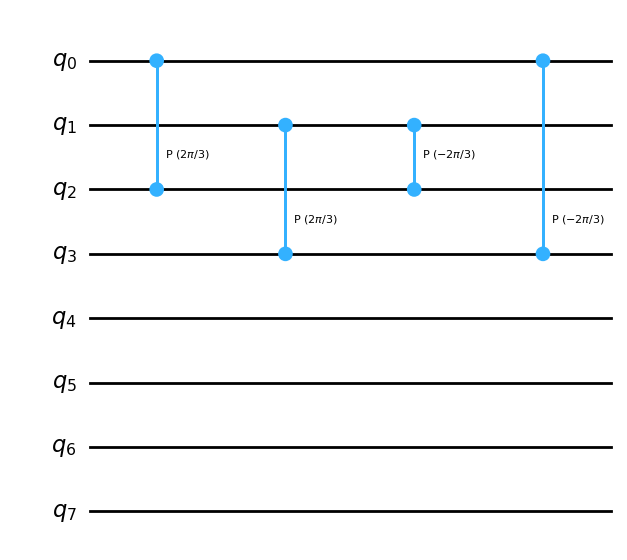

In [22]:
CzCirc.decompose().draw('mpl')

In [23]:
from qiskit.quantum_info import Statevector
mtx = Statevector(CzCirc).to_operator()

In [24]:
mtx

Operator([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          ...,
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2, 2, 2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2, 2, 2, 2))


In [25]:
mtx

Operator([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          ...,
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2, 2, 2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2, 2, 2, 2))
